# Scikit-learn으로 ML 모델링부터 ML Pipeline까지

출처: [https://towardsdatascience.com/from-ml-model-to-ml-pipeline-9f95c32c6512](https://towardsdatascience.com/from-ml-model-to-ml-pipeline-9f95c32c6512)

# From ML Model to ML Pipeline With Scikit-learn in Python
Machine learning model을 구축하는 것은 올바른 알고리즘을 선택하고 hyperparameter를 tuning하는 것만이 아닙니다. model experimentation이 시작되기 전에 data wrangling, feature engineering을 하는 데 상당한 시간이 소요됩니다. 이러한 preprocessing은 workflow를 대응하기 힘드고, 추적하기 어렵게 만들 수 있습니다. ML model에서 ML pipeline에 초점을 맞추고 preprocessing을 모델 구축의 필수 부분으로 보는 것은 workflow를 보다 체계적으로 유지하는 데 도움이 될 수 있습니다. 이 아티클에서는 먼저 모델의 데이터를 preprocessing하는 잘못된 방법을 살펴본 다음, ML pipeline을 구축하는 두 가지 올바른 접근 방식을 배웁니다.

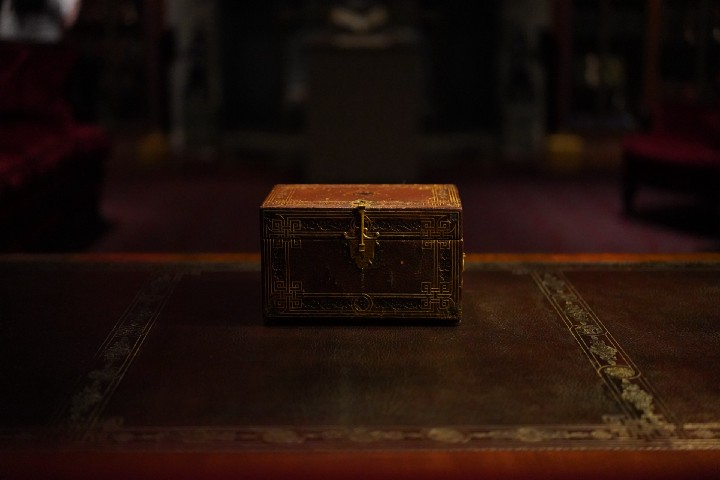

ML pipeline은 context에 따라 여러 가지 정의가 있습니다. 이 아티클에서 ML Pipeline은 preprocessing steps와 모델의 collection으로 정의됩니다. 즉, raw data가 ML pipeline에 전달되면 데이터를 올바른 형식으로 preprocessing하고 모델을 사용하여 데이터를 채점한 후, 예측 점수가 튀어나옵니다.

# 0. Setup

In [1]:
from seaborn import load_dataset
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(display="diagram")

columns = ['alive', 'class', 'embarked', 'who', 'alone', 'adult_male']
df = load_dataset("titanic").drop(columns=columns)
df["deck"] = df["deck"].astype("object")
print(df.shape)
df.head()

(891, 9)


,survived,pclass,sex,age,sibsp,parch,fare,deck,embark_town
0,0,3,male,22.0,1,0,7.2500,NaN,Southampton
1,1,1,female,38.0,1,0,71.2833,C,Cherbourg
2,1,3,female,26.0,0,0,7.9250,NaN,Southampton
3,1,1,female,35.0,1,0,53.1000,C,Southampton
4,0,3,male,35.0,0,0,8.0500,NaN,Southampton


나중에 참고할 수 있도록 자주 사용하는 variables를 정의합니다.

In [2]:
SEED = 42
TARGET = "survived"
FEATURES = df.columns.drop(TARGET)

NUMERICAL = df[FEATURES].select_dtypes("number").columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: pclass, age, sibsp, parch, fare
Categorical features: deck, embark_town, sex


이제 첫번째 접근을 살펴봅시다

#  1. Wrong approach
preprocessing을 할 때, 아래처럼 pandas methods를 사용하는 것은 흔치 않습니다

In [3]:
df_num_imputed = df[NUMERICAL].fillna(df[NUMERICAL].mean())
df_num_scaled = df_num_imputed.subtract(df_num_imputed.min(), axis=1)\
                              .divide(df_num_imputed.max()-df_num_imputed.min(), axis=1)

df_cat_imputed = df[CATEGORICAL].fillna("missing")
df_cat_encoded = pd.get_dummies(df_cat_imputed, drop_first=True)

df_preprocessed = df_num_scaled.join(df_cat_encoded)
df_preprocessed.head()

,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male
0,1.0,0.271174,0.125,0.0,0.014151,0,0,0,0,0,0,1,0,1,0,1
1,0.0,0.472229,0.125,0.0,0.139136,0,1,0,0,0,0,0,0,0,0,0
2,1.0,0.321438,0.000,0.0,0.015469,0,0,0,0,0,0,1,0,1,0,0
3,0.0,0.434531,0.125,0.0,0.103644,0,1,0,0,0,0,0,0,1,0,0
4,1.0,0.434531,0.000,0.0,0.015713,0,0,0,0,0,0,1,0,1,0,1


여기서는 missing values와 0에서 1 사이의 scaled numerical variables, one-hot encoding을 한 categoricla variables로 imputing했습니다. preprocessing 후, 데이터를 분할하고 모델을 훈련시킵니다:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, df[TARGET],
                                                    test_size=.2, random_state=SEED,
                                                    stratify=df[TARGET])

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

이제 이 접근 방식이 왜 잘못되었는지 살펴봅시다:

- **Imputation:** 전체 데이터 세트가 아니라 training 데이터의 mean 값으로 numerical variables를 imputing했어야 합니다.

- **Scaling:** Min과 Max도 training 데이터에서 계산되어야 합니다.

- **Encoding:** Categories는 training 데이터에서 추론해야 합니다. 또한, 데이터가 preprocessing 전에 분할되더라도 ```pd.get_dummies(X_train)``` 및 ```pd.get_dummies(X_test)```를 사용한 one-hot encoding은 서로 다른 training 및 test 데이터를 만들 수 있습니다(칼럼이 category에 따라 다를 수 있음). 따라서, ```pd.get_dummies()```는 모델에 대한 데이터를 준비할 때 one-hot-encoding에 사용하지 않아야 합니다.

> test 데이터는 전처리 전에 따로 보관해야 합니다. preprocessing에 사용되는 mean, min 및 max와 같은 모든 sttistics는 training 데이터에서 만들어져야 합니다. 그렇지 않으면, data leakage problem이 발생합니다.

이제 모델을 평가해 보겠습니다. 여기서는 ROC-AUC를 사용하여 모델을 평가합니다. ROC-AUC를 계산하는 함수는 후속 approach를 평가하는 데 유용하기 때문에 만들어줍니다

In [5]:
def calculate_roc_auc(model_pipe, X, y):
    """Calculate roc auc score. 
    
    Parameters:
    ===========
    model_pipe: sklearn model or pipeline
    X: features
    y: true target
    """
    y_proba = model_pipe.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)
  
print(f"Train ROC-AUC: {calculate_roc_auc(model, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(model, X_test, y_test):.4f}")

Train ROC-AUC: 0.8669
Test ROC-AUC: 0.8329


# 2. Correct approach but …
데이터를 먼저 분할하고, Scikit-learn의 transformers를 사용하여 데이터를 preprocessing해 data leakage를 방지합니다.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=TARGET), df[TARGET],
                                                    test_size=.2, random_state=SEED,
                                                    stratify=df[TARGET])
num_imputer = SimpleImputer(strategy="mean")
train_num_imputed = num_imputer.fit_transform(X_train[NUMERICAL])

scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(train_num_imputed)

cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")
train_cat_imputed = cat_imputer.fit_transform(X_train[CATEGORICAL])

encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)
train_cat_encoded = encoder.fit_transform(train_cat_imputed)

train_preprocessed = np.concatenate((train_num_scaled, train_cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
pd.DataFrame(train_preprocessed, columns=columns, index=X_train.index).head()

,pclass,age,sibsp,parch,fare,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_missing,embark_town_Queenstown,embark_town_Southampton,embark_town_missing,sex_male
692,1.0,0.369285,0.000,0.000000,0.110272,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
481,0.5,0.369285,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
527,0.0,0.369285,0.000,0.000000,0.432884,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
855,1.0,0.220910,0.000,0.166667,0.018250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
801,0.5,0.384267,0.125,0.166667,0.051237,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


이제 모델을 학습시켜 봅시다

In [7]:
model = LogisticRegression()
model.fit(train_preprocessed, y_train)

LogisticRegression()

evaluate 전에 위와 똑같은 방식으로 test 데이터를 전처리합니다

In [8]:
test_num_imputed = num_imputer.transform(X_test[NUMERICAL])
test_num_scaled = scaler.transform(test_num_imputed)
test_cat_imputed = cat_imputer.transform(X_test[CATEGORICAL])
test_cat_encoded = encoder.transform(test_cat_imputed)
test_preprocessed = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)

print(f"Train ROC-AUC: {calculate_roc_auc(model, train_preprocessed, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(model, test_preprocessed, y_test):.4f}")

Train ROC-AUC: 0.8670
Test ROC-AUC: 0.8332


이번에는 approach는 정확했습니다. 하지만, 좋은 코드를 작성하는 것은 정확한 것에 그치지 않습니다. 위 코드는 각 preprocessing 단계에 대해 training 데이터 세트와 test 데이터 세트 모두에 대한 중간 출력을 저장했지만, preprocessing 단계의 수가 증가하면 이러한 과정은 곧 지겨워져 test 데이터 preprocessing 단계를 놓치는 것과 같은 오류가 발생하기 쉽습니다. 이 코드는 보다 체계적이고 능률적이며 읽기 쉽게 만들 수 있으며, 이는 다음 단계에서 보여줍니다.

# 3. Elegant approach \#1
Scikit-learn의 ```Pipeline``` 및 ```ColumnTransformer```를 사용하여 이전 코드를 간소화해 보겠습니다.

In [10]:
numerical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ("num", numerical_pipe, NUMERICAL),
    ("cat", categorical_pipe, CATEGORICAL)
])

pipe = Pipeline([
    ("proprocessors", preprocessors),
    ("model", LogisticRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('proprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['deck', 'embark_town', 'sex'], dtype='object'))])),
                ('model', LogisticRegression())])

pipeline은:

- numerical과 categorical로 input 데이터를 나누고

- 동시에 두 그룹을 preprocessing 합니다

- 그 후, 두개의 전처리된 그룹을 합치고

- 전처리된 데이터를 모델에 전달합니다


raw 데이터가 훈련된 pipeline에 전달되면 preprocessing하고 예측합니다. 즉, 더 이상 training 및 test 데이터 세트에 대한 중간 결과를 저장할 필요가 없습니다. 보이지 않는 데이터에 점수를 매기는 것은 ```pipe.predict()```으로 매우 간단합니다. 이제 모델의 성능을 평가해 보겠습니다.

In [11]:
print(f"Train ROC-AUC: {calculate_roc_auc(pipe, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(pipe, X_test, y_test):.4f}")

Train ROC-AUC: 0.8670
Test ROC-AUC: 0.8332


transformation이 정확히 동일하지만, 더 깔끔한 방식으로 코드가 작성되었기 때문에 이전 approach의 성능과 일치하는 것을 확인하는 것이 좋습니다. 여기서의 예에서는 이 아티클에 표시된 네 가지 approach 중 가장 좋은 접근 방식입니다.

```OneHotEncoder```나 ```SimpleImputer```와 같은 Scikit-learn의 즉시 사용 가능한 transformer는 빠르고 효율적입니다. 하지만, 이러한 미리 만들어진 transformer가 항상 우리가 원하는 preprocessing 요구 사항을 만족하는 것은 아닙니다. 이러한 경우, 다음 approach에 익숙해지면 맞춤형 preprocessing 방법을 더 잘 control할 수 있습니다.

# 4. Elegant approach \#2
이 approach에서는 Scikit-learn을 사용하여 custom transformer를 만듭니다. 우리가 친숙했던 preprocessing 단계가 custom transformer로 어떻게 바뀌는지 보는 것이 이해하는 데 도움이 되기를 바랍니다. custom transformer의 사용 예시에 관심이 있다면 이 [GitHub repository](https://github.com/zluvsand/ml_pipeline)를 확인하세요.

In [15]:
# Transformer
# fit(), transform() 메소드가 있으며, 데이터를 원하는 포맷으로 바꿔주는데 도움을 줍니다.
# OneHotEncoder, MinMaxScaler가 예

# Estimator
# fit(), predict() 메소드가 있으며, 여기서는 모델과 같은 의미로 사용됩니다.
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, features, method="constant", value="missing"):
        self.features = features
        self.method = method
        self.value = value
        
    def fit(self, X, y=None):
        if self.method == "mean":
            self.value = X[self.features].mean()
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = X[self.features].fillna(self.value)
        return X_transformed
    
    
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        self.min = X[self.features].min()
        self.range = X[self.features].max() - self.min
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = (X[self.features] - self.min) / self.range
        return X_transformed
    
    
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, drop="first"):
        self.features = features
        self.drop = drop
        
    def fit(self, X, y=None):
        self.encoder = OneHotEncoder(sparse=False, drop=self.drop)
        self.encoder.fit(X[self.features])
        return self
    
    def transform(self, X):
        X_transformed = pd.concat([X.drop(columns=self.features).reset_index(drop=True),
                                  pd.DataFrame(self.encoder.transform(X[self.features]))],
                                  axis=1)
        return X_transformed
    
    
pipe = Pipeline([
    ("num_imputer", Imputer(NUMERICAL, method="mean")),
    ("scaler", Scaler(NUMERICAL)),
    ("cat_imputer", Imputer(CATEGORICAL)),
    ("encoder", Encoder(CATEGORICAL)),
    ("model", LogisticRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('num_imputer',
                 Imputer(features=Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object'),
                         method='mean',
                         value=pclass     2.308989
age       29.807687
sibsp      0.492978
parch      0.390449
fare      31.819826
dtype: float64)),
                ('scaler',
                 Scaler(features=Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object'))),
                ('cat_imputer',
                 Imputer(features=Index(['deck', 'embark_town', 'sex'], dtype='object'))),
                ('encoder',
                 Encoder(features=Index(['deck', 'embark_town', 'sex'], dtype='object'))),
                ('model', LogisticRegression())])

이전과 달리 각 단계는 output을 input으로 차례대로 전달합니다. 이제 모델을 평가할 시간입니다:

In [16]:
print(f"Train ROC-AUC: {calculate_roc_auc(pipe, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(pipe, X_test, y_test):.4f}")

Train ROC-AUC: 0.8670
Test ROC-AUC: 0.8332


이번 포스팅은 여기까지였습니다. 후자의 2가지 접근 방식을 사용할 때, 한 가지 장점은 모델에서만이 아니라 전체 pipeline에서 hyperparameter를 수행할 수 있다는 것입니다. ML pipeline 사용을 시작하는 실용적인 방법을 배웠기를 바랍니다.